# Implementing Energy Function

In [1]:
import xml.etree.ElementTree as ET
from collections import defaultdict
from math import tanh
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from idpconfgen.libs.libstructure import Structure, col_element

%matplotlib inline

## Preparating Structures and Parameters

### Loading structures

Here we will load two conformers, one clash-free and other with clashes, that were created by the current version of `IDPConfGen` where clashes were computed with a simple hard sphere clash optimization, which we want to optimize here via an energy function. We will use `Structure()` to extract the coordinates and labels of the conformers. Keep in mind that, when during the building process, coordinates and labels will be already in memory.

In [2]:
good = Path('conformer_good.pdb')
bad = Path('conformer_bad.pdb')

In [15]:
# good
gs = Structure(good)
gs.build()
gcoods = gs.coords

# bad
bs = Structure(bad)
bs.build()
bcoods = bs.coords

# atoms labels are the same for both conformers
elements = gs.data_array[:, col_element]
print(elements[:20])

['N' 'C' 'C' 'O' 'C' 'H' 'H' 'H' 'H' 'N' 'C' 'C' 'O' 'C' 'H' 'H' 'H' 'H'
 'H' 'N']


### Loading parameters from Force Fields

This is a crucial part as parameters need to be in tune with each other.

I will build the parameters here as I implement the different energy functions.

In [4]:
# the original XML file was taken from the OpenMM repository
# https://github.com/openmm/openmm/tree/master/wrappers/python/simtk/openmm/app/data
with open('../data/protein.ff14SB.xml', 'r') as fin:
    ff14SB = ET.fromstring(fin.read())

In [5]:
forcefield_params = defaultdict(dict)
for atom in ff14SB[-1][1:]:
    
    # simplistic approach using only element
    atom_type = atom.attrib['type'].split('-')[-1]
    
    forcefield_params[atom_type]['epsilon'] = float(atom.attrib['epsilon'])
    forcefield_params[atom_type]['sigma'] = float(atom.attrib['sigma'])

In [6]:
forcefield_params.keys()

dict_keys(['C', 'CA', 'CB', 'CC', 'CN', 'CR', 'CT', 'CV', 'CW', 'C*', 'CX', 'H', 'HC', 'H1', 'HA', 'H4', 'H5', 'HO', 'HS', 'HP', 'N', 'NA', 'NB', 'N2', 'N3', 'O', 'O2', 'OH', 'S', 'SH', 'CO', '2C', '3C', 'C8'])

In [7]:
forcefield_params['C']

{'epsilon': 0.359824, 'sigma': 0.3399669508423535}

### Prepares data arrays

Prepares data before performing calculations, in order to allow for parameters indexing.

In [8]:
epsilons = np.array([
    forcefield_params[element]['epsilon']
    for element in elements
    ])
print(epsilons[:5])

[0.71128  0.359824 0.359824 0.87864  0.359824]


In [13]:
## WRONGGGG
r_min = np.array([
    (2 * forcefield_params[element]['sigma'])**(1/6)
    for element in elements
    ])
print(np.round(r_min[:10], 2))

[0.93 0.94 0.94 0.92 0.94 0.77 0.77 0.77 0.77 0.93]


In [14]:
# these values have direct relationship with what reported in:
# Chernyshov, I. Yu., Ananyev, I. V. & Pidko, E. A. Revisiting van der Waals Radii: From Comprehensive Structural Analysis to Knowledge‐Based Classification of Interatomic Contacts. Chemphyschem 21, 370–376 (2020).
r_min = np.array([
    2**(1/6) * forcefield_params[element]['sigma']
    for element in elements
    ])
print(np.round(r_min[:10], 2))

[0.36 0.38 0.38 0.33 0.38 0.12 0.12 0.12 0.12 0.36]


## Defining Energy Terms

... and implementation

### vdW term

$$
E_{vdW} = 
\begin{cases}
      \infty, \qquad\qquad\qquad\qquad\qquad\quad r_{ij} < r_{ij}^{*} \\
      4\varepsilon_{ij}\left[\left(\cfrac{\sigma_{ij}}{r_{ij}}\right)^{12} - \left(\cfrac{\sigma_{ij}}{r_{ij}}\right)^{6}\right], \qquad r_{ij} > r_{ij}^{*}
    \end{cases}
$$

Alternatively,

$$
E_{VDW} = \cfrac{ACOEFF}{r^{12}_{ij}} - \cfrac{BCOEFF}{r^{6}_{ij}}
$$

For this we can compute first-hand the $ACOEFF$ and $BCOEFF$, and rewrite the equation such that:

$$
ACOEFF = \varepsilon_{ij} r^{12}_{0} \\
BCOEFF = 2\varepsilon_{ij} r^{6}_{0} \\
\varepsilon_{ij} = \sqrt{\varepsilon_{i}\varepsilon_{j}} \\
\sigma_{ij} = \cfrac{\sigma_{i} + \sigma_{j}}{2} \\
r_{0} = \sqrt[6]{2} \cdot \sigma_{ij} \\
r^{*}_{ij} = \alpha (r_{i} + r_{j}), \quad \alpha = 0.8
$$

In [3]:
(0.324999852378 * 2)**(1/6)

0.9307196001944212

#### Precomputing ACOEFF and BCOEFF

$\sigma$ and $\varepsilon$ values are as extracted from the `protein.ff14SB.xml`.

In [10]:
def calc_e_ij(epsilons):
    """Calculate epsilon for ij pair."""
    indices = np.triu_indices(epsilons.size, k=+1)    
    result = np.sqrt(np.outer(epsilons, epsilons)[indices])
    assert result.size == (epsilons.size * epsilons.size - epsilons.size) // 2
    return result

In [11]:
epsilons_ij = calc_e_ij(epsilons)
epsilons_ij

array([0.5059008 , 0.5059008 , 0.79054352, ..., 0.0656888 , 0.24024323,
       0.24024323])

In [12]:
def calc_r0(rmin):
    """Calculates the r0 for all atom pairs."""
    indices = np.triu_indices(rmin.size, k=+1)
    result = (rmin[:, None] + rmin)[indices]
    _expected_size = (rmin.size * rmin.size - rmin.size) // 2
    assert result.size == _expected_size, (result.size, _expected_size)
    return result

In [13]:
r0 = calc_r0(r_min)
print(r0[:5])

[1.86844954 1.86844954 1.84704918 1.86844954 1.70400521]


## Effective Born Radius

$$
R^{-1}_{i} (\mathring{A}) = \widetilde{\rho}^{-1}_{i} - \rho^{-1}_{i} \tanh(\alpha\Psi - \beta\Psi^{2} + \gamma\Psi^{3})
$$

Where,

$$
\rho_{i} (\text{atom radii in } \mathring{A}) \\
\widetilde{\rho}_{i} = \rho_{i} - 0.09 \\
\Psi = I\rho_{i} \\
I = scaling factor \\
\begin{vmatrix}
	\alpha \\
	\beta \\
	\gamma 
\end{vmatrix}\begin{vmatrix}
	0.8 & 1 \\
	0.0 & 0.8 \\
	2.91 & 4.85
\end{vmatrix}
$$



In [34]:
def calc_Ri(pi, a, b, g, I, ptilde=0.09):
    """Calculates Ri according to Onufriev 2004."""
    ppi = pi - ptilde
    Y = I*ppi
    return (ppi**-1 - pi**-1 * np.tanh(a*Y - b*Y**2 + g*Y**3))**(-1)

### Demonstration of Ri

Bellow we reproduce Fig. 1 from Onufriev *et. al.* 2004.

In [36]:
pi = 1.7  # for carbon atom

# generate a series of scaling I
I = np.linspace(0, 1, num=50)

# using first set of scalars
Ri_distribution_1 = calc_Ri(pi, 0.8, 0.0, 2.91, I)

# using second set of scalars
Ri_distribution_2 = calc_Ri(pi, 1, 0.8, 4.85, I)

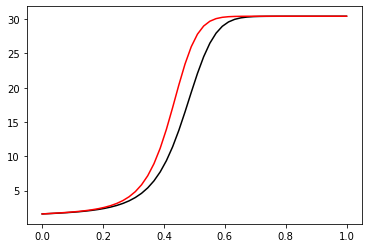

In [38]:
# plot results
plt.plot(I, Ri_distribution_1, color='black')
plt.plot(I, Ri_distribution_2, color='red')

# General Python Tests

In [14]:
a  = np.char.array(list('abcd'))
print(a[:,None]+a)

[['aa' 'ab' 'ac' 'ad']
 ['ba' 'bb' 'bc' 'bd']
 ['ca' 'cb' 'cc' 'cd']
 ['da' 'db' 'dc' 'dd']]


In [15]:
a

chararray(['a', 'b', 'c', 'd'], dtype='<U1')

In [16]:
a[:,None]+a

chararray([['aa', 'ab', 'ac', 'ad'],
           ['ba', 'bb', 'bc', 'bd'],
           ['ca', 'cb', 'cc', 'cd'],
           ['da', 'db', 'dc', 'dd']], dtype='<U2')

In [17]:
b = np.arange(9)
b
il2 = np.triu_indices(9, k=1)

In [18]:
(b[:, None]+b)[il2]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  3,  4,  5,  6,  7,  8,  9,  5,  6,
        7,  8,  9, 10,  7,  8,  9, 10, 11,  9, 10, 11, 12, 11, 12, 13, 13,
       14, 15])

In [19]:
il1 = np.triu_indices(4, k=+1)

In [20]:
a = np.arange(16).reshape(4, 4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [21]:
a[il1]

array([ 1,  2,  3,  6,  7, 11])

# Testing some values of the force field

In [29]:
pi = 1.7
ppi = pi - 0.09
a = 0.8
b = 0
g = 2.91

I = np.linspace(0, 1, num=50)
Y = I*ppi

eq = (ppi**-1 - pi**-1 * np.tanh(a*Y - b*Y**2 + g*Y**3))**(-1)
eq2 = (ppi**-1 - pi**-1 * np.tanh(1*Y - 0.8*Y**2 + 4.85*Y**3))**(-1)

In [39]:
import sympy

In [60]:
rr = sympy.Symbol('r')
rho = sympy.Symbol('rho')

In [61]:
sympy.integrate((rr-rho)*(1/rr**4), rr)

-(3*r - 2*rho)/(6*r**3)